![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Sarcasm Detection

### **Description**
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

In this hands-on project, **the goal is to build a model** ***to detect whether a sentence is sarcastic or not***, using **Bidirectional LSTMs**.


### **Dataset**
#### **News Headlines dataset for Sarcasm Detection**
The dataset is collected from two news websites, **theonion.com** and **huffingtonpost.com**. 

This new dataset has the following advantages over the existing Twitter datasets:
  Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements

#### **Content**
**Each record consists** of three attributes:
  1. **is_sarcastic: 1 if the record is sarcastic otherwise 0**
  2. **headline**: the headline of the news article
  3. ***article_link***: link to the original news article. Useful in collecting supplementary data

#### **Reference**
https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection


#### **Acknowledgement**
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

### Load Data (3 Marks)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Mapping My Google Drive, Where Sarcasm Data is Stored**

In [3]:
data_path = "/content/drive/My Drive/AIML/Labs/NLP/Sarcasm Detection/"

**Loading Data from the Google Drive and Checking the top 5 data rows**

In [4]:
import pandas as pd

df = pd.read_json(data_path + 'Sarcasm_Headlines_Dataset.json', lines=True)
df.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Drop **`article_link`** from dataset (3 Marks)

**Deleting the column article_Link as it will not be used for sarcastic detection**

In [5]:
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


**Let's Review the distribution of the Data to verify data sparsity, also if any missing values in the Data**

***Checking for NaN values:***

In [6]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

## Observation: No NULL Values in the dataset

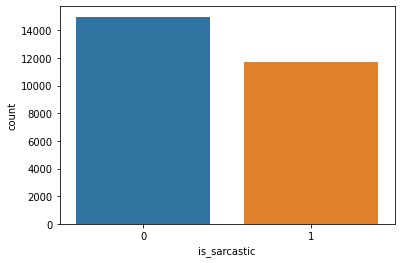

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="is_sarcastic")

In [8]:
df['is_sarcastic'].value_counts() 

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [9]:
df.shape

(26709, 2)

## Observation
There are **14895 False** sarcasm and **11724 True** sarcasm in the Data set **out of Total 26709 Headlines**, Also, from the Countplot, we can visualize the distribution of the Sarcasm, from which We can say **Dataset is Balanced.**

### Get length of each headline and add a column for that (3 Marks)

Adding a Column **headline_length** at the end of DataFrame with values of **Total No of Words for each headline**.

In [10]:
df['headline_length']=df['headline'].str.len()
df.head(5)

,headline,is_sarcastic,headline_length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


## Visualize the distribution of word length in a each headline text using histplot

In [11]:
df['headline_length'][df['is_sarcastic']==1].value_counts(ascending=False)

62     255
55     234
52     231
58     226
50     222
      ... 
237      1
190      1
238      1
254      1
199      1
Name: headline_length, Length: 133, dtype: int64

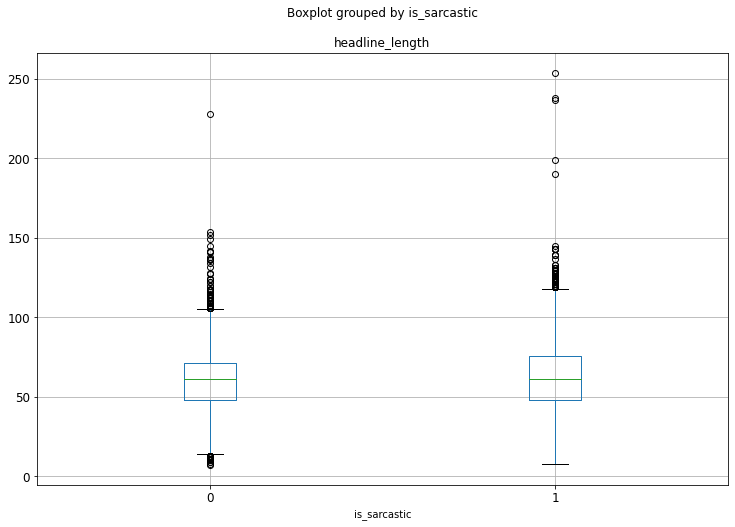

In [12]:
boxplot = df.boxplot(column='headline_length', by='is_sarcastic', figsize=(12,8), fontsize='12')

### Observation:
1. **Headlines with sarcastic=1(True) has less outlier compared to sarcastic=0(False)**
2. **Median No of Words count is Approximately 60-65**
3. **Outliers treatment is not considered here, considering it will be padded with the 0 at the time of embedding.**

### Visualizing the distribution of the No of Words in Each Headline

Text(0.5, 0.98, 'No of word length in each text')

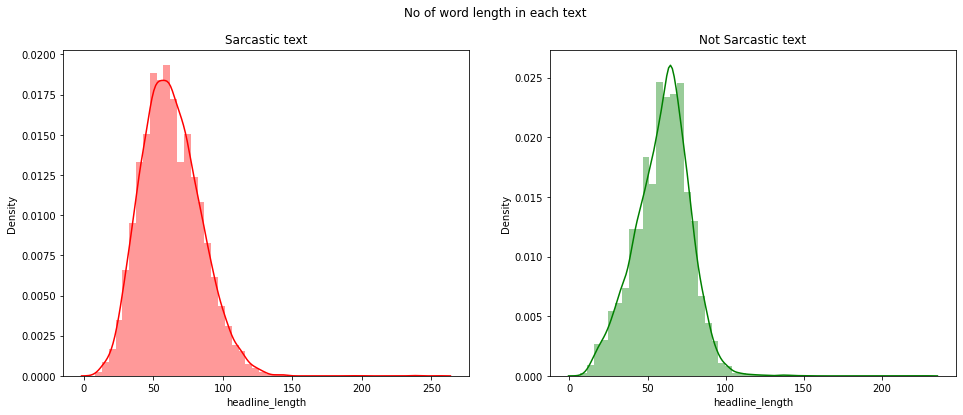

In [13]:
import warnings
warnings.filterwarnings("ignore")

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))

sns.distplot(df['headline_length'][df['is_sarcastic']==1],ax=ax1,color='red')
ax1.set_title('Sarcastic text')

sns.distplot(df['headline_length'][df['is_sarcastic']==0],ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')

fig.suptitle('No of word length in each text')

### Initialize parameter values
- Set values for **max_features, maxlen, & embedding_size**
- **max_features**: Number of words to take from tokenizer(most frequent words)
- **maxlen**: Maximum length of each sentence to be limited to 25
- **embedding_size**: size of embedding vector

In [14]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words (3 Marks)
- **Initialize Tokenizer object with number of words as 10000**
- **Fit the tokenizer object** on headline column
- **Convert the text to sequence**


In [15]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer with number of words as 10000
tokenizer = Tokenizer(num_words=max_features)

# Fit the tokenizer object on headline column
tokenizer.fit_on_texts(df.headline)

# Convert the text to sequence
tokenizer_seq = tokenizer.texts_to_sequences(df.headline)

**Let's Review The number of unique words in the text corpus dictionary**

In [16]:
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))  

The number of unique words in the text corpus dictionary : 29656


**Let's View Some of the Sample Data from the word_index**

In [17]:
# Initialize limit
S=3000
N = 5
    
# Print first N items in dictionary from S position
out = dict(list(tokenizer.word_index.items())[S: S+N])  
        
# printing result   
print("sample word_index Dictionary items are : " + str(out))  

sample word_index Dictionary items are : {'lasting': 3001, 'newest': 3002, 'worldwide': 3003, 'gates': 3004, 'drives': 3005}


**A Sample Tokenized Sequence Before Padding**

In [18]:
tokenizer_seq[0]

[307, 678, 3336, 2297, 47, 381, 2575, 5, 2576, 8433]

**Corresponsing headline for the above tokenizer_seq**

In [19]:
df['headline'][0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

## Observation:
**tokenizer_seq[0] is showing 10 sequence No, But in Actual headline[0] there are 12 words**, So, Something is missing here, **Lets verify what is missing?**

In [20]:
for i in (df['headline'][0]).split():
  print(i, tokenizer.word_index.get(i))

former 307
versace 15114
store 678
clerk 3336
sues 2297
over 47
secret 381
'black 2575
code' 15115
for 5
minority 2576
shoppers 8433


## Observation:
**versace(15114) and code'(15115) is beyond max_features of 10000 So, these 2 words index is not present in the tokenizer_seq**

### Pad sequences (3 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [21]:
from keras.preprocessing import sequence
from keras.utils import to_categorical

X_train = sequence.pad_sequences(tokenizer_seq, maxlen = maxlen, padding='post')
Y_train=to_categorical(df["is_sarcastic"].values)

print("The shape of the trainable data : {}".format(X_train.shape))
print("The shape of the labels for the data is : {}".format(Y_train.shape))

The shape of the trainable data : (26709, 25)
The shape of the labels for the data is : (26709, 2)


**Lets Review the first item after the padding**

In [22]:
X_train[0]

array([ 307,  678, 3336, 2297,   47,  381, 2575,    5, 2576, 8433,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

## Observation:
**Padding successfull with max length of 25**

### Vocab mapping
**- There is no word for 0th index**

In [23]:
dict(list(tokenizer.word_index.items())[0:1])

{'to': 1}

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary
***Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.***

In [24]:
num_words = len(tokenizer.word_index) + 1
print('num_words',num_words)

num_words 29657


### Load Glove Word Embeddings (3 Marks)

In [25]:
from zipfile import ZipFile
with ZipFile(data_path + "/" + 'glove.6B.zip', 'r') as z:
  z.extractall()

**About:** GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. Reference Link: https://nlp.stanford.edu/projects/glove/


## Output:
Glove Word Embedding extracted on my Google Drive, it has the following embedding files,


1.   glove.6B.50d.txt
2.   glove.6B.100d.txt
3.   glove.6B.200d.txt
4.   glove.6B.300d.txt





### Create embedding matrix

In [26]:
import numpy as np

EMBEDDING_FILE = data_path + "/" +'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

**Shape of Created Matrix**

In [27]:
embedding_matrix.shape

(29657, 200)

## Define model (5 Marks)


**The below Sequence is Used for Model Preparation**

1.   **Add a Sequential model instance** 
2.   **Add Embedding layer, From Pre-Trained Glove Weight Matrix**
3.   **Bidirectional(LSTM) layer, return_sequences=True, dropout=0.2**
4.   **Flatten the Layer Before Adding the Dense Layer**
5.   **Add Dense(With 50 hidden Layer)**
6.   **Add Dropout layers**
7.   **In the end Add a Final Dense Layer with Sigmoid Activation for binary classification.**

In [28]:
#Building the model
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional 

model=Sequential()
model.add(Embedding(num_words, embedding_size, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(200,return_sequences=True, dropout=0.2)))
model.add(Flatten())
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))

### Visualising the summary of the network used

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           5931400   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 400)           641600    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                500050    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 7,073,152
Trainable params: 1,141,752
Non-trainable params: 5,931,400
______________________________________

### Compile the model (3 Marks)

1. **Use Optimizer as Adam**
2. **Use Binary Crossentropy as loss**
3. **Use Accuracy as metrics**

In [30]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

### Fit the model (4 Marks)

### Splittting the data into training and testing sets before fitting the model Using a 70% - 30% split for the data

In [96]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train,test_size=0.3)

### Fit the Model
1. **Lets Use 30% of Training Data as Validation Data**
2. **Use EarlyStopping with monitoring validation loss of 0.001**

In [98]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, verbose=1, mode='auto')
callbacks_list = [earlystop]
# Returns the loss value & metrics values for the model in test mode.
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.3, callbacks=callbacks_list) 

Epoch 1/5
103/103 [==============================] - 1s 13ms/step - loss: 0.0357 - accuracy: 0.9866 - val_loss: 0.1354 - val_accuracy: 0.9692
Epoch 2/5
103/103 [==============================] - 1s 12ms/step - loss: 0.0259 - accuracy: 0.9901 - val_loss: 0.1528 - val_accuracy: 0.9679
Epoch 00002: early stopping


### Evaluate the Model

In [99]:
train_performance=model.evaluate(x_train,y_train)
print("The loss of the model on Training Data is - " , train_performance[0]*100)
print("Accuracy of the model on Training Data is - " , train_performance[1]*100)

test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}%".format(test_performance[0]*100))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))

585/585 [==============================] - 2s 4ms/step - loss: 0.0486 - accuracy: 0.9895
The loss of the model on Training Data is -  4.858778789639473
Accuracy of the model on Training Data is -  98.95164966583252
251/251 [==============================] - 1s 4ms/step - loss: 0.1474 - accuracy: 0.9668
The loss of the model on the test set : 14.740018546581268%
The accuracy of the model on the test set : 96.68039679527283%


### Observation:
 **Accuracy of the model on Test Data is -  96.68% with 14.74% of Loss with 97% which gives a high confidence on the Model**


### Plot the Training and Testing Accuracy With Loss

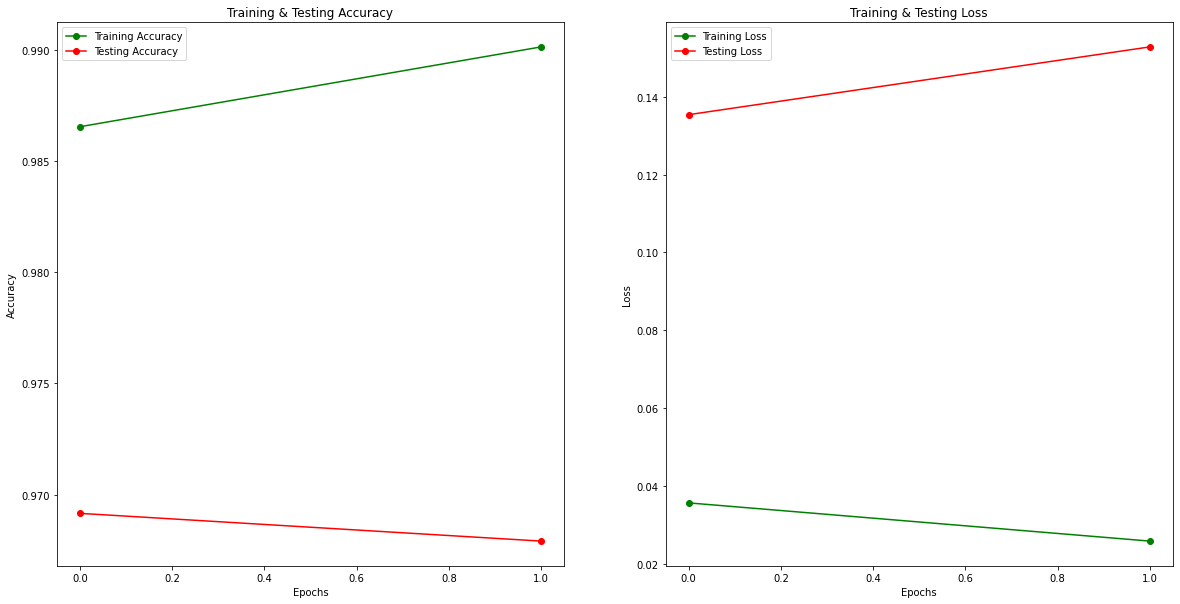

In [102]:
epochs = [i for i in range(2)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Predict the Model with one sample

In [133]:
#Lets Consider it is x_test[[100]]
x_test[[100]]

array([[  24,  652,   78,  477, 2719,  267,    1,    3,   40,  434,   79,
         145,    1,  143,   94,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

In [131]:
#Actual Words that contains in x_test[[100]]
for i in (x_test[100]):
  for k, v in tokenizer.word_index.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if v == i:
        print(k)

how
following
my
heart
led
me
to
the
one
person
i
need
to
love
most


**Reference:** https://www.huffpost.com/entry/love-after-divorce_n_5242852

**Actual Headline:** Following My Heart Led Me To The One Person I Need To Love Most -- Myself

In [147]:
#Predict whether it is a sarcasm or Not?

print("Predicting for the headline: ",x_test[[100]],'\n')
y_pred = model.predict(x_test[[100]])
print(y_pred[0])
#get the actual int value 0 or 1 , As Y Has 2 value 0 and 1, always tking it from 1st indices, 
#which contains the relevant value of sarcasm other indices is the vice versa of the first one.

pred=int(y_pred[0][0])

if(pred == 1):
  print("headline is : sarcastic (", pred,')') 
else:
  print("Mheadline is : non-sarcastic (", pred,')') 

Predicting for the headline:  [[  24  652   78  477 2719  267    1    3   40  434   79  145    1  143
    94    0    0    0    0    0    0    0    0    0    0]] 

[1.0000000e+00 4.5605436e-13]
headline is : sarcastic ( 1 )
